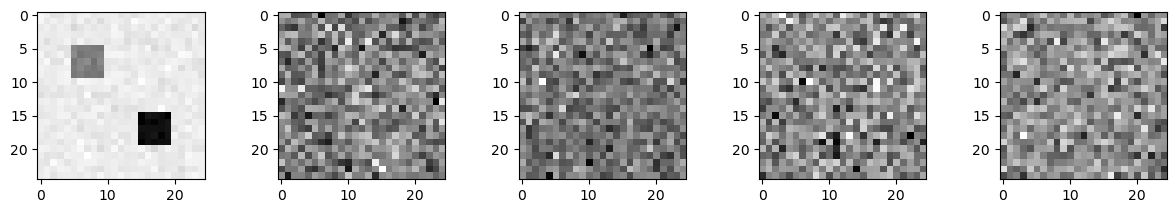

In [15]:
#JadeForAD
import jadeR
import numpy as np
import matplotlib.pyplot as plt
pcNum = 100
icNum = 5
size = 25
frameNum = 624
frame_as_column = True

# u = np.load('D:/屈清宇/Widefield_data_analysis/data/artificial_data/FS_15_05_U.npy')
# u = u[:,:pcNum]
u = np.load('D:/屈清宇/Widefield_data_analysis/data/artificial_data/FS_20_40_20_20_00_15.npy')
u = np.reshape(u,(size*size,frameNum))
# print(u.shape)
if frame_as_column:
    u = np.transpose(u)
demixU = jadeR.jadeR(u,m=icNum)
demixU_inv = np.linalg.pinv(demixU)

originU = np.dot(demixU,u)

fig = plt.figure(figsize = [15,10])
for i in range(0,icNum):
    fig.add_subplot(4,5,i+1)
    #option 1
    if frame_as_column:
        Out = originU[i].reshape((size,size))
    else:
        Out = demixU_inv[:,i].reshape((size,size))
    plt.imshow(Out,cmap='gray')



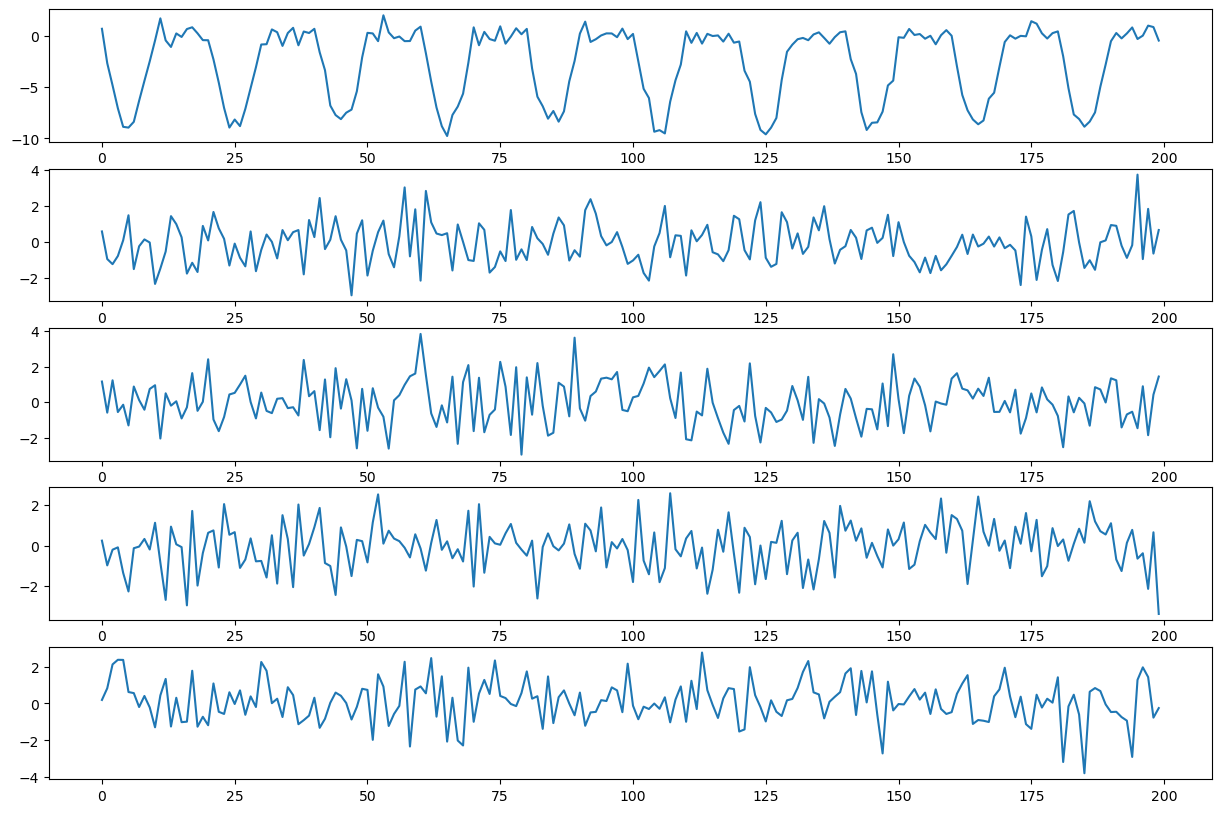

In [16]:
#计算demixU的伪逆

fig = plt.figure(figsize = [15,10])
for i in range(0,icNum):
    fig.add_subplot(icNum,1,i+1)
    y= np.zeros(200)
    for j in range(0,200):
        if frame_as_column:
            y[j]= demixU_inv[j,i]
        else:
            y[j]= originU[i,j]
    plt.plot(y)
plt.show()

In [ ]:
import numpy as np

SVTcorr = np.load('D:/屈清宇/Widefield_data_analysis/data/mvingbar0/SVTcorr.npy')
sigma =np.dot(SVTcorr,SVTcorr.T)
count = 0
for i in range(sigma.shape[0]):
    count += sigma[i,i]
    if count/np.sum(np.diag(sigma))>0.95:
        print(i)
        break

In [1]:
#JADE

import jadeR
import numpy as np
from wfield import *

U = np.load('D:/屈清宇/Widefield_data_analysis/data/mvingbar0/U.npy')
SVTcorr = np.load('D:/屈清宇/Widefield_data_analysis/data/mvingbar0/SVTcorr.npy')

video = reconstruct(U,SVTcorr)[::10,::2,::2]
print(video.shape)

# shapeU = U.shape
# shapeSVTcorr = SVTcorr.shape
# print(shapeU)
# print(shapeSVTcorr)
# U_merge = np.zeros((shapeU[2],shapeU[0]*shapeU[1]))
# for i in range(shapeU[2]):
#     U_merge[i,:] = U[:,:,i].reshape(-1)
# for j in range(shapeU[2]):
#     U_merge[j,:] = U_merge[j,:]/np.linalg.norm(U_merge[j,:])
# O = jadeR.jadeR(U_merge,m=40,verbose=False)
# del U
#输出U_merge点乘U_merge的转置的对角线元素



(313, 256, 256)


In [ ]:
from IPython.display import clear_output
for i in range(150):
    plt.imshow(video[i,:,:],cmap='gray')
    plt.show()
    clear_output(wait=True)
    plt.pause(0.1)

In [2]:
X = np.zeros((video.shape[0],video.shape[1]*video.shape[2]))
for i in range(video.shape[0]):
    X[i,:] = video[i,:,:].reshape(-1)
print(X.shape)


(313, 65536)


In [20]:
O = jadeR.jadeR(X,m=40,verbose=False)
O_inv = np.linalg.pinv(O)
originX = np.dot(O,X)

d:\屈清宇\Widefield_data_analysis\widefield_imaging_analysis\jadeR.py:212: ComplexWarning: Casting complex values to real discards the imaginary part
  CM[:,Range] = Qij
d:\屈清宇\Widefield_data_analysis\widefield_imaging_analysis\jadeR.py:218: ComplexWarning: Casting complex values to real discards the imaginary part
  CM[:,Range]	= Qij
d:\屈清宇\Widefield_data_analysis\widefield_imaging_analysis\jadeR.py:327: ComplexWarning: Casting complex values to real discards the imaginary part
  return B.astype(origtype)


In [6]:
from wfield import *

# shapeO = O.shape
# signalNum = 40
# U_merge = U_merge[:signalNum,:]
# origin = np.dot(O,U_merge)
# np.save('D:/屈清宇/Widefield_data_analysis/data/mvingbar0/Origin_mvingbar0.npy',origin)
# result = np.empty((shapeO[0],512,512))

#brain reference
name1 = 'D:/屈清宇/Widefield_data_analysis/data/mvingbar0/dorsal_cortex_landmarks.json'
lmarks = load_allen_landmarks(name1)

ccf_regions_reference,proj,brain_outline = allen_load_reference('dorsal_cortex')
# convert reference to fit image
# atlas_im, areanames, brain_mask = atlas_from_landmarks_file(name1,do_transform = True) # this loads the untransformed atlas
# ccf_regions_im = allen_transform_regions(lmarks['transform'],ccf_regions_reference,
#                                         resolution = lmarks['resolution'],
#                                         bregma_offset = lmarks['bregma_offset'])
#convert image to fit reference
U1 = np.zeros((512,512,shapeO[0]))
for i in range(shapeO[0]):
    U1[:,:,i] = origin[i].reshape((512,512))
stack = SVDStack(U1,SVTcorr)
stack.set_warped(1, M = lmarks['transform'])
stack.set_warped(True)
ccf_regions = allen_transform_regions(None,ccf_regions_reference,
                                      resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])
atlas, areanames, brain_mask = atlas_from_landmarks_file(name1) # this loads the atlas in transformed coords

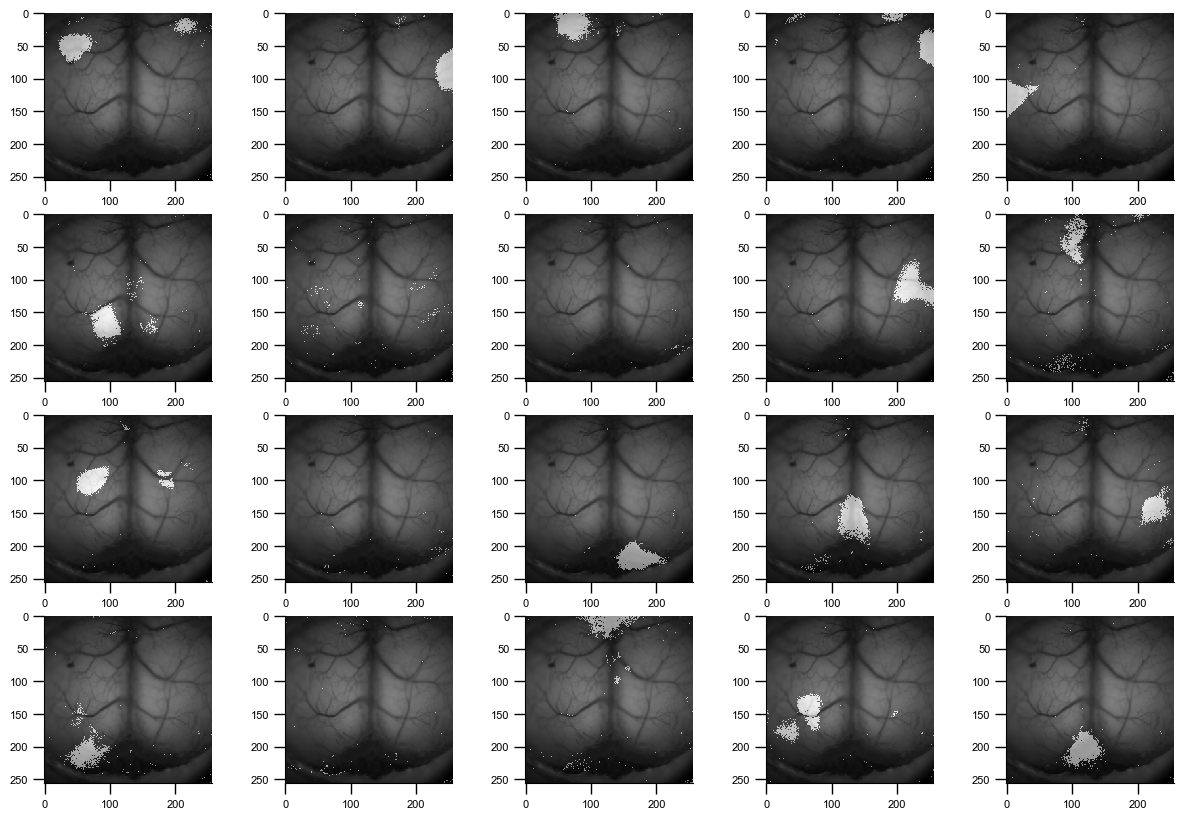

In [23]:
import matplotlib.pyplot as plt
frame_average = np.load('D:/屈清宇/Widefield_data_analysis/data/mvingbar0/frames_average.npy')
frame_average = frame_average[0,::2,::2]
fig = plt.figure(figsize = [15,10])
for i in range(20,40):
    fig.add_subplot(4,5,i-20+1)
    #option 1
    Out = originX[i].reshape((256,256))
    #option2 : warped
    # Out = stack.U_warped[:,:,i]

    # result[i,:,:] = Out
    # compute z score(相对突出性) of Out
    Out = (Out - np.mean(Out))/np.std(Out)
    #binarize Out
    threshold = 2.5
    Out[(Out<threshold) & (Out>-threshold)] = 0
    Out[(Out>=threshold) | (Out<=-threshold)] = 1
    plt.imshow(Out,cmap='gray')
    plt.imshow(frame_average,cmap='gray',alpha=0.5)
    # for i,r in ccf_regions_im.iterrows():
    #     plt.plot(r['left_x'],r['left_y'],'w',lw=1)
    #     plt.plot(r['right_x'],r['right_y'],'w',lw=1)
    # plt.axis('off')
plt.show()


# #将result转化为unit16格式
# result = result - np.min(result)
# result = result/np.max(result)
# result = result*65535
# result = result.astype(np.uint16)

# import tifffile
# from tifffile import imwrite
# imwrite('D:/屈清宇/Widefield_data_analysis/data/looming/process/20240718-181900-wfield/ICA.tif',result,imagej=True)


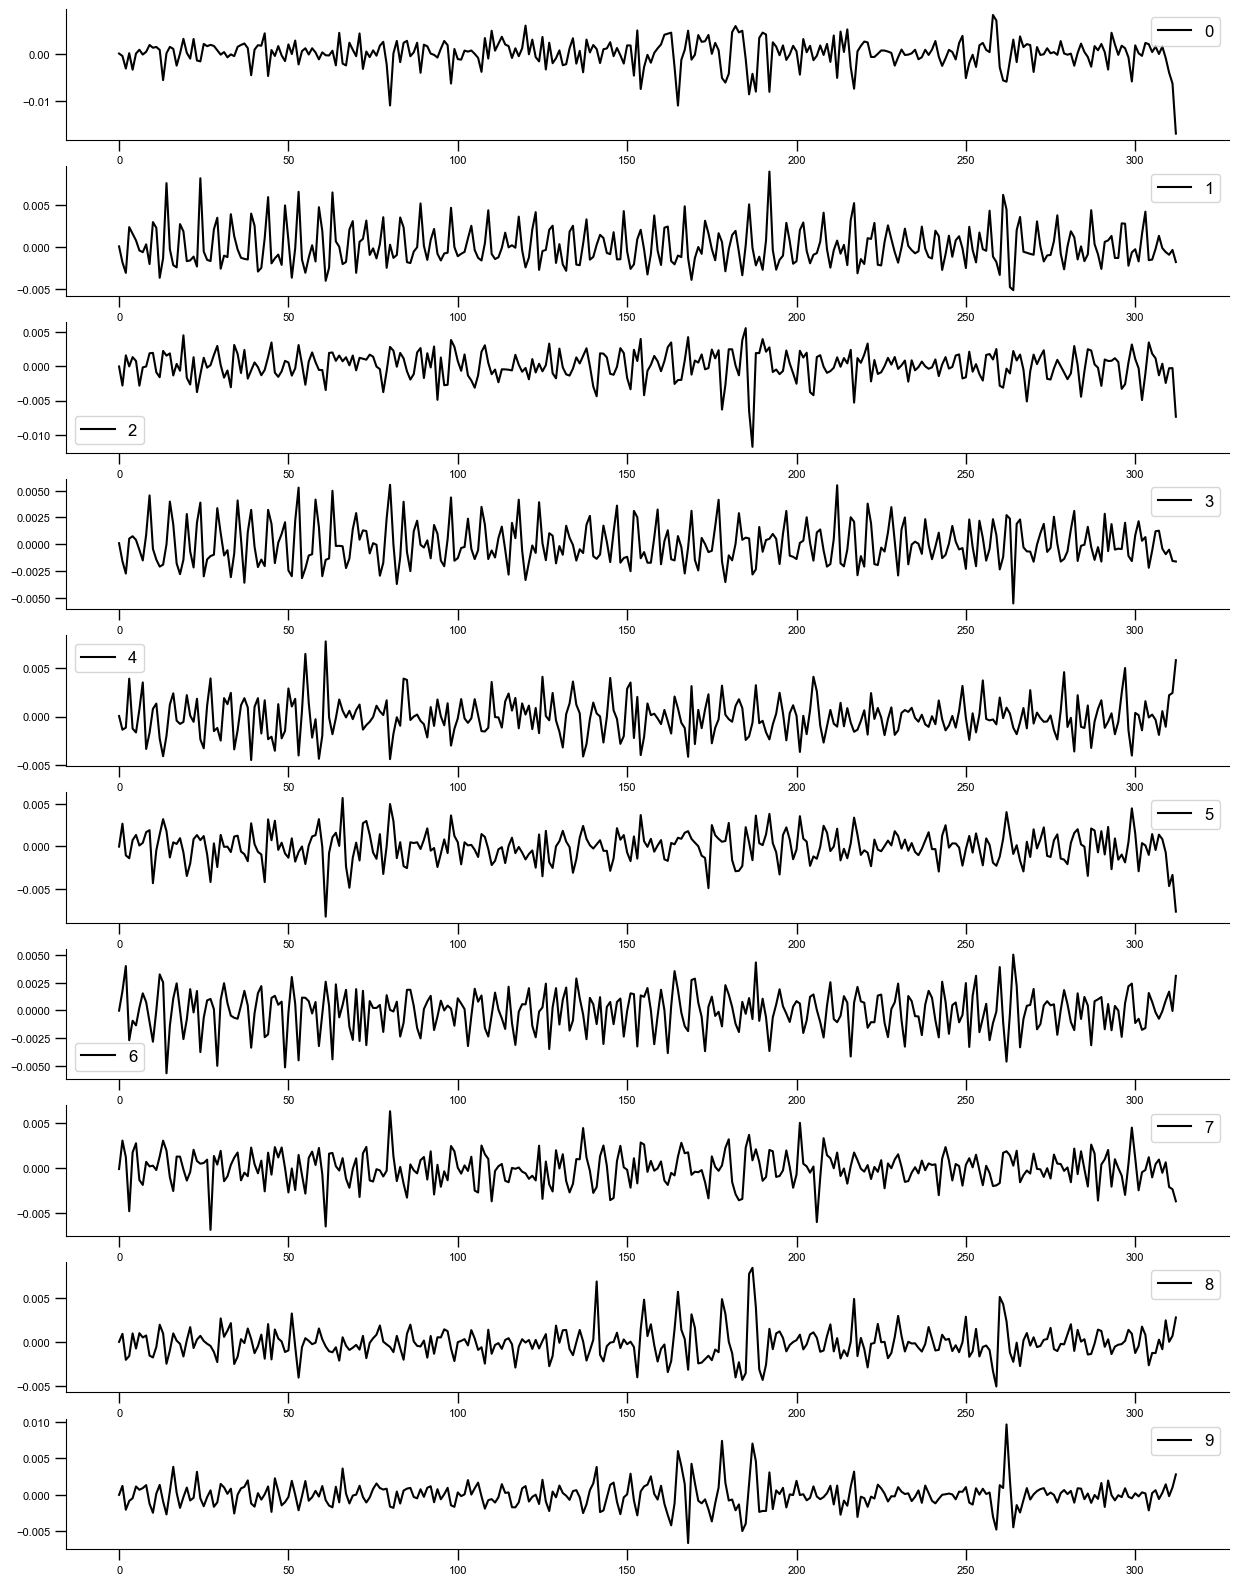

In [22]:
fig = plt.figure(figsize = [15,20])
for i in range(0,10):
    fig.add_subplot(10,1,i+1)
    y= np.zeros(313)
    for j in range(0,313):
        y[j]= O_inv[j,i]
    #画图，每隔图的label为i
    plt.plot(y,label = i)
    plt.legend()
plt.show()

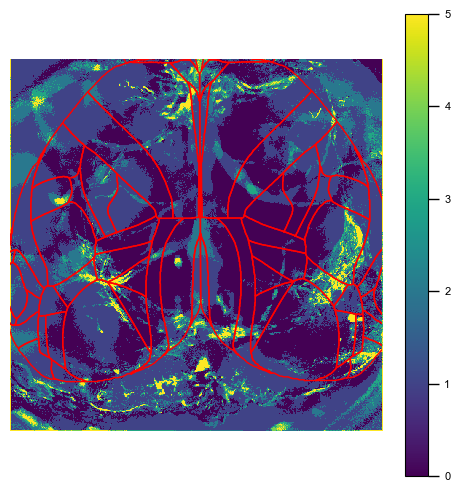

In [42]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = [6,6])
for i,r in ccf_regions_im.iterrows():
    plt.plot(r['left_x'],r['left_y'],'r',lw=1)
    plt.plot(r['right_x'],r['right_y'],'r',lw=1)
plt.axis('off')
total_out = np.zeros((512,512))
for i in range(0,40):
    #option 1
    Out = origin[i].reshape((512,512))
    #option2 : warped
    # Out = stack.U_warped[:,:,i]

    # result[i,:,:] = Out
    # compute z score(相对突出性) of Out
    Out = (Out - np.mean(Out))/np.std(Out)
    #binarize Out
    threshold = 2.5
    Out[(Out<threshold) & (Out>-threshold)] = 0
    Out[(Out>=threshold) | (Out<=-threshold)] = 1
    total_out += Out
    # total_out[total_out>1] = 1
plt.imshow(total_out, vmax=5)
plt.colorbar()


plt.show()